In [1]:
import os
path = os.path.abspath(os.getcwd())

In [2]:
import matplotlib.pyplot as plt
import random as rd
import pandas as pd
import numpy as np
import time
import csv

from scipy.optimize import curve_fit

from nistrng import check_eligibility_all_battery, run_all_battery, SP800_22R1A_BATTERY#, pack_sequence
from nistrng.sp800_22r1a import MonobitTest, FrequencyWithinBlockTest, RunsTest, LongestRunOnesInABlockTest, \
    DiscreteFourierTransformTest, NonOverlappingTemplateMatchingTest, SerialTest, ApproximateEntropyTest, \
    CumulativeSumsTest, RandomExcursionTest, RandomExcursionVariantTest

In [3]:
# Parameters
bitsize: np.uint64 = 64
mask: np.uint64 = np.uint64(2**bitsize - 1)
'0x'+format(mask, 'X')

'0xFFFFFFFFFFFFFFFF'

In [4]:
def printif(verbose, string):
    if verbose:
        print(string)

In [5]:
def write_to_csv(filename, data):
    with open(filename, 'w', newline='') as f:
        writer = csv.writer(f)
        writer.writerows(data)
        
def append_to_csv(filename, data):
    with open(filename, 'a', newline='') as f:
        writer = csv.writer(f)
        writer.writerows(data)

# I/ Operational functions
## 1) Binary operations

In [6]:
def xor(a, b):
    return (np.uint64(a) ^ np.uint64(b)) & mask

In [7]:
def add(a, b): 
    with np.errstate(over='ignore'):  # suppresses overflow warnings
        result = np.uint64(a) + np.uint64(b)
    return result & mask

In [8]:
def bitrol(n, r):
    return ((np.uint64(n) << np.uint64(r)) & mask) | ((np.uint64(n) >> np.uint64(bitsize - r)) & mask)

In [9]:
def swab(value):
    if value < 0 or value > 0xFFFF:
        raise ValueError("Value must be a 16-bit unsigned integer")

    return np.uint64((value & np.uint64(0xFF)) << np.uint64(8)) | ((value & np.uint64(0xFF00)) >> np.uint64(8))

In [10]:
def binprint(pool):
    s = "["
    for i in pool[0:len(pool)-1]: 
        s += bin(i) + ", "
    s += bin(pool[-1]) + "]"
    print(s)

In [11]:
def strprint(pool):
    s = "["
    for i in pool[0:len(pool)-1]: 
        s += str(i) + ", "
    s += str(pool[-1]) + "]"
    print(s)

In [12]:
def pack_sequence_64(sequence: np.ndarray) -> np.ndarray:
    sequence_array = np.array(sequence, dtype=np.uint64)
    return np.unpackbits(sequence_array.view(np.uint8)).astype(np.uint8)

def pack_sequence_32(sequence: np.ndarray) -> np.ndarray:
    sequence_array = np.array(sequence, dtype=np.uint32)
    return np.unpackbits(sequence_array.view(np.uint8)).astype(np.uint8)

if bitsize == 32:
    pack_sequence = pack_sequence_32
else: #64 bit case
    pack_sequence = pack_sequence_64

## 2) Entropy gathering functions

In [13]:
def hsiphash_perm(pool):
    assert(bitsize==32)
    rol32 = bitrol
    
    a, b, c, d = pool[0], pool[1], pool[2], pool[3]
    
    a = add(a, b)
    b = rol32(b, 5)
    b = xor(b, a)
    a = rol32(a, 16)
    
    c = add(c, d)
    d = rol32(d, 8)
    d = xor(d, c)
    
    a = add(a, d)
    d = rol32(d, 7)
    d = xor(d, a)
    
    c = add(c, b)
    b = rol32(b, 13)
    b = xor(b, c)
    c = rol32(c, 16)
    
    return [a, b, c, d]

In [14]:
def siphash_perm(pool):
    assert(bitsize==64)
    rol64 = bitrol
    
    a, b, c, d = pool[0], pool[1], pool[2], pool[3]
    
    a = add(a, b)
    b = rol64(b, 13)
    b = xor(b, a)
    a = rol64(a, 32)
    
    c = add(c, d)
    d = rol64(d, 16)
    d = xor(d, c)
    
    a = add(a, d)
    d = rol64(d, 21)
    d = xor(d, a)
    
    c = add(c, b)
    b = rol64(b, 17)
    b = xor(b, c)
    c = rol64(c, 32)
    
    return [a, b, c, d]

In [15]:
if bitsize == 32: 
    fastmix_perm = hsiphash_perm
else: #64 bit case
    fastmix_perm = siphash_perm

In [16]:
def siphash_mix(pool, input1, input2):
    pool[3] = xor(pool[3], input1)
    pool = fastmix_perm(pool)
    pool[0] = xor(pool[0], input1)
    
    pool[3] = xor(pool[3], input2)
    pool = fastmix_perm(pool)
    pool[0] = xor(pool[0], input2)
    
    return pool

In [17]:
def rot_mix(pool, input1, input2, r): 
    pool = xor(pool, input1)
    pool = xor(pool, input2)
    pool = bitrol(pool, r)
    
    return pool

In [18]:
def fast_mix_old_perm(pool):
    a, b, c, d = pool[0], pool[1], pool[2], pool[3]

    a = add(a, b)
    c = add(c, d)
    b = bitrol(b, 6)
    d = bitrol(d, 27)
    d = xor(d, a)
    b = xor(b, c)

    a = add(a, b)
    c = add(c, d)
    b = bitrol(b, 16)
    d = bitrol(d, 14)
    d = xor(d, a)
    b = xor(b, c)

    a = add(a, b)
    c = add(c, d)
    b = bitrol(b, 6)
    d = bitrol(d, 27)
    d = xor(d, a)
    b = xor(b, c)

    a = add(a, b)
    c = add(c, d)
    b = bitrol(b, 16)
    d = bitrol(d, 14)
    d = xor(d, a)
    b = xor(b, c)

    return [a, b, c, d]

In [19]:
def fast_mix(pool, input1, input2, input3, input4):
    pool[0] ^= input1
    pool[1] ^= input2
    pool[2] ^= input3
    pool[3] ^= input4
    
    return fast_mix_old_perm(pool)

## 3) Distributions
### A. Timestamp value

In [20]:
def generate_cauchy(gamma, x0, size):
    cauchy_array = np.random.standard_cauchy(size) * gamma + x0
    return cauchy_array.astype(int)

bins  = 2000
range = (-262144, 262144)


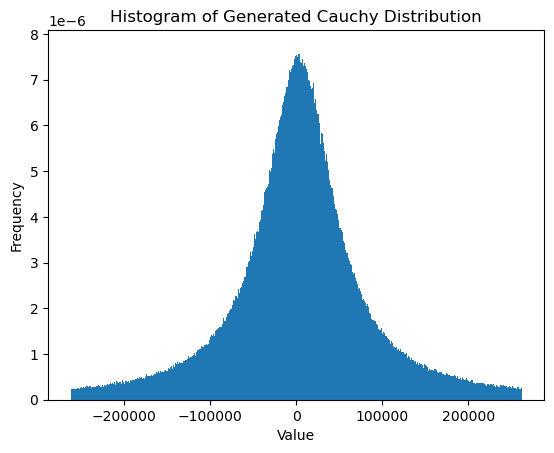

In [21]:
gamma, x0, size = 48031, 3818, 4000000
theta_distrib = generate_cauchy(gamma, x0, size)

bins = int(np.sqrt(size))
a = 2**18
plot_range = (-a,a)

print("bins  =", bins)
print("range =", plot_range)

plt.hist(theta_distrib, bins=bins, density=True, range=plot_range)
plt.title("Histogram of Generated Cauchy Distribution")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.show()

In [22]:
def draw_cauchy_params(N): 
    cauchy_gamma_array = np.random.uniform(4e4, 8e4, N)
    cauchy_x0_array = np.random.uniform(3e3, 8e3, N)
    cauchy_delta_array = np.random.uniform(2e7, 9e7, N)
    
    return cauchy_gamma_array, cauchy_x0_array, cauchy_delta_array

### B.Jiffy value

In [23]:
def init_jiffy_arrays():
    global jiffy_delta_distribution, jiffy_elements, jiffy_probabilities
    
    jiffy_delta_distribution = [
        [0, 0.419073], [1, 0.027795], [2, 0.004821],
        [3, 0.004008], [4, 0.455692], [5, 0.088511]
    ]

    jiffy_elements = [element for element, _ in jiffy_delta_distribution]
    jiffy_probabilities = [probability for _, probability in jiffy_delta_distribution]

def draw_jiffy_deltas(N):
    drawn_elements = rd.choices(jiffy_elements, jiffy_probabilities, k=N)
    return [np.uint64(i) for i in drawn_elements]

def draw_jiffy_seed():
    if bitsize == 32:
        low, high = np.uint64(1e8), np.uint64(1e9)
    else:
        low, high = np.uint64(1e8), np.uint64(8e9)
    
    return rd.randrange(low, high)

def draw_jiffy_values(N):
    seed = draw_jiffy_seed()
    drawn_deltas = draw_jiffy_deltas(N)
    
    drawn_values = []
    for delta in drawn_deltas:
        seed += delta
        drawn_values.append(seed)
        
    return [np.uint64(i) for i in drawn_values]

In [24]:
init_jiffy_arrays()
draw_jiffy_deltas(3)

[0, 4, 1]

In [25]:
draw_jiffy_values(3)

[2230486437, 2230486437, 2230486441]

### C. Instruction Pointer value

In [26]:
def init_ip_arrays():
    global instruction_pointer_distribution, ip_elements, ip_probabilities
    
    instruction_pointer_distribution = [
        [4112549988, 0.729635], [3995109476, 0.177747], [3709896804, 0.072718],
        [4005702796, 0.010259], [3995352108, 0.004920], [4005727176, 0.000448],
        [4246767716, 0.000396], [4123167688, 0.000297], [4112865224, 0.000261],
        [3995247160, 0.000223], [3995185056, 0.000115], [4112960576, 0.000110],
        [4112786712, 0.000072], [4113351664, 0.000070], [4123167300, 0.000070],
        [3720514504, 0.000058], [3710212040, 0.000053], [3712703804, 0.000050],
        [3995424712, 0.000050], [4113352520, 0.000048]
    ]

    ip_elements = [element for element, _ in instruction_pointer_distribution]
    ip_probabilities = [probability for _, probability in instruction_pointer_distribution]

def draw_ip_values(N):
    drawn_elements = rd.choices(ip_elements, ip_probabilities, k=N)
    return [np.uint64(i) for i in drawn_elements]

In [27]:
init_ip_arrays()
draw_ip_values(3)

[3995109476, 4112549988, 3995109476]

#### Simulating IP values

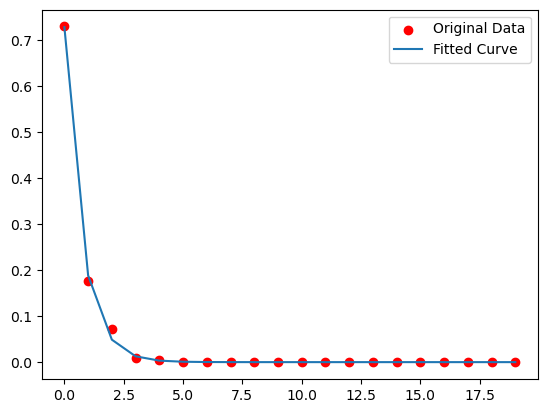

In [28]:
xdata = list(range(len(instruction_pointer_distribution)))
ydata = [point[1] for point in instruction_pointer_distribution]

# Double exponential fitting
def double_exponential(x, a, b, c):
    return a * np.exp(b * x) + c 
ip_params, covariance = curve_fit(double_exponential, xdata, ydata, p0=(1, -1, 1))

plt.scatter(xdata, ydata, color="red", label="Original Data")
plt.plot(xdata, [double_exponential(x, *ip_params) for x in xdata], label="Fitted Curve")
plt.legend()
plt.show()

In [29]:
def generate_ip_probabilities(n, ip_params):
    noise = np.random.uniform(0.8, 1.2, n)
    probabilities = [double_exponential(x, *ip_params)*noise[i] for i,x in enumerate(range(n))]
    
    # Normalize the probabilities
    total_prob = sum(probabilities)
    probabilities = [p / total_prob for p in probabilities]
    
    # Generate n data points
    low, high = int(37e8), int(43e8)
    data_points = np.random.default_rng().integers(low, high, size=n)
    
    return [[data_points[i], probabilities[i]] for i in range(n)]

In [30]:
def generate_ip_arrays(n):
    global ip_elements, ip_probabilities
    
    generated_ip = generate_ip_probabilities(n, ip_params)
    sorted_ip = sorted(generated_ip, key=lambda x: x[1], reverse=True)
    
    ip_elements = [element for element, _ in sorted_ip]
    ip_probabilities = [probability for _, probability in sorted_ip]

In [31]:
generate_ip_arrays(20)
draw_ip_values(3)

[4026854956, 3721663860, 4026854956]

### C. IRQ value

In [32]:
def init_irq_arrays():
    global irq_distribution, irq_elements, irq_probabilities
    
    irq_distribution = [
        [90, 0.563053], [76, 0.052640], [77, 0.049272],
        [10, 0.044676], [70, 0.038246], [75, 0.035131],
        [69, 0.033727], [73, 0.033374], [72, 0.029866],
        [71, 0.026564], [74, 0.024222], [67, 0.018798],
        [78, 0.017512], [68, 0.014154], [89, 0.011819]
    ]

    irq_elements = [element for element, _ in irq_distribution]
    irq_probabilities = [probability for _, probability in irq_distribution]

def draw_irq_values(N):
    drawn_elements = rd.choices(irq_elements, irq_probabilities, k=N)
    return [np.uint64(i) for i in drawn_elements]

In [33]:
init_irq_arrays()
draw_irq_values(3)

[90, 90, 90]

#### Simulating IRQ values

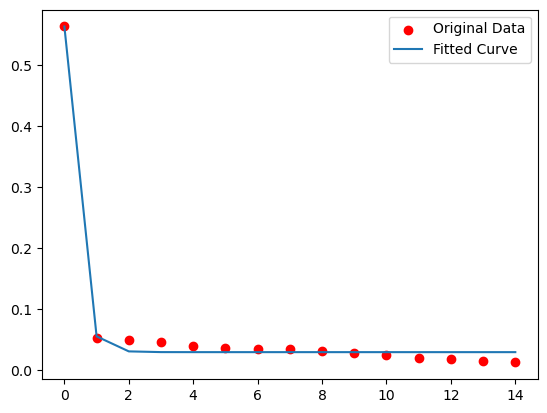

In [34]:
xdata = list(range(len(irq_distribution)))
ydata = [point[1] for point in irq_distribution]

# Double exponential fitting
def double_exponential(x, a, b, c):
    return a * np.exp(b * x) + c 
irq_params, covariance = curve_fit(double_exponential, xdata, ydata, p0=(1, -1, 1))

plt.scatter(xdata, ydata, color="red", label="Original Data")
plt.plot(xdata, [double_exponential(x, *irq_params) for x in xdata], label="Fitted Curve")
plt.legend()
plt.show()

In [35]:
def generate_irq_probabilities(n, irq_params):
    noise = np.random.uniform(0.8, 1.2, n)
    probabilities = [double_exponential(x, *irq_params)*noise[i] for i,x in enumerate(range(n))]
    
    # Normalize the probabilities
    total_prob = sum(probabilities)
    probabilities = [p / total_prob for p in probabilities]
    
    # Generate n data points
    data_points = np.random.default_rng().integers(1, 100, size=n)
    
    return [[data_points[i], probabilities[i]] for i in range(n)]

In [36]:
def generate_irq_arrays(n):
    global irq_elements, irq_probabilities
    generated_irq = generate_irq_probabilities(n, ip_params)
    sorted_irq = sorted(generated_irq, key=lambda x: x[1], reverse=True)
    
    irq_elements = [element for element, _ in sorted_irq]
    irq_probabilities = [probability for _, probability in sorted_irq]

In [37]:
generate_irq_arrays(20)
draw_irq_values(3)

[19, 93, 19]

# II/ Simulation

In [38]:
chosen_tests: dict = {
    'monobit': MonobitTest(),
    'frequency_within_block': FrequencyWithinBlockTest(),
    'runs': RunsTest(),                                                        #unreliable
    'longest_run_ones_in_a_block': LongestRunOnesInABlockTest(),
#     'dft': DiscreteFourierTransformTest(),                                     #unreliable
    'non_overlapping_template_matching': NonOverlappingTemplateMatchingTest(), #unreliable
#     'serial': SerialTest(),                                                    #slow 
#     'approximate_entropy': ApproximateEntropyTest(),                           #slow
#     'cumulative sums': CumulativeSumsTest(),                                   #unreliable
    'random_excursion': RandomExcursionTest(),
#     'random_excursion_variant': RandomExcursionVariantTest()                   #unapplicable
}

In [39]:
def score_to_rating(score: float) -> float:
    difference = abs(score - 0.5)
    rating = 1 - 2 * difference
    return rating**2

## A. Siphash

In [40]:
def make_siphash_sim(gamma, x0, delay, rounds, N, tests, verbose): 
    pools = [ [np.uint64(0) for i in range(4) ] for _ in range(N)]
    output = []
    
    generate_ip_arrays(20), generate_irq_arrays(20)
    delta_values = np.array([np.uint64(delay) for _ in range(N)])
    timestamp_values = np.array([np.uint64(0) for _ in range(N)])
    
    for r in range(rounds): 
        printif(verbose, "Round" + str(r))
        
        # Generating timestamp with Theta & Delta
        theta_values = np.array(generate_cauchy(gamma, x0, N))
        delta_values = delta_values + theta_values
        timestamp_values = [np.uint64(timestamp_values[i] + delta_values[i]) & mask for i in range(N)]
        
        # Drawing IP and IRQ
        ip_values = draw_ip_values(N)
        irq_values = draw_irq_values(N)
        
        # Calling fast_mix
        for i in range(N): 
            pools[i] = siphash_mix(pools[i], timestamp_values[i], ip_values[i] ^ swab(irq_values[i]))
                
        flat_pool = np.concatenate(pools)
        binary_sequence = pack_sequence(flat_pool)
        
        if tests == None: 
            eligible_battery: dict = check_eligibility_all_battery(
                binary_sequence, SP800_22R1A_BATTERY)
            tests = eligible_battery
            
        results = run_all_battery(binary_sequence, tests, False)
        
        for result, elapsed_time in results:            
            output.append(["siphash", gamma, x0, delay, r, result.name, result.score, result.passed])
            if result.passed:
                printif(verbose, "\t - PASSED - score: " + str(np.round(result.score, 3)) + " - " + result.name + " - elapsed time: " + str(elapsed_time) + " ms")
            else:
                printif(verbose, "\t - FAILED - score: " + str(np.round(result.score, 3)) + " - " + result.name + " - elapsed time: " + str(elapsed_time) + " ms")

    return output

In [41]:
make_siphash_sim(400, 0, 38229868, 8, 5000, chosen_tests, True)

Round0
	 - FAILED - score: 0.0 - Monobit - elapsed time: 0 ms
	 - FAILED - score: 0.0 - Frequency Within Block - elapsed time: 1 ms
	 - FAILED - score: 0.0 - Runs - elapsed time: 140 ms
	 - FAILED - score: 0.006 - Longest Run Ones In A Block - elapsed time: 494 ms
	 - PASSED - score: 1.0 - Non Overlapping Template Matching - elapsed time: 1571 ms
	 - PASSED - score: 0.957 - Random Excursion - elapsed time: 1683 ms
Round1
	 - PASSED - score: 0.973 - Monobit - elapsed time: 0 ms
	 - PASSED - score: 0.997 - Frequency Within Block - elapsed time: 1 ms
	 - PASSED - score: 0.586 - Runs - elapsed time: 140 ms
	 - PASSED - score: 0.054 - Longest Run Ones In A Block - elapsed time: 495 ms
	 - PASSED - score: 1.0 - Non Overlapping Template Matching - elapsed time: 1268 ms
	 - PASSED - score: 0.971 - Random Excursion - elapsed time: 1675 ms
Round2
	 - PASSED - score: 0.84 - Monobit - elapsed time: 0 ms
	 - PASSED - score: 0.804 - Frequency Within Block - elapsed time: 1 ms
	 - PASSED - score: 0.8

[['siphash', 400, 0, 38229868, 0, 'Monobit', 4.433121665907815e-140, False],
 ['siphash',
  400,
  0,
  38229868,
  0,
  'Frequency Within Block',
  1.692901990794426e-91,
  False],
 ['siphash', 400, 0, 38229868, 0, 'Runs', 5.532859946729106e-37, False],
 ['siphash',
  400,
  0,
  38229868,
  0,
  'Longest Run Ones In A Block',
  0.0055531823727329645,
  False],
 ['siphash',
  400,
  0,
  38229868,
  0,
  'Non Overlapping Template Matching',
  0.9999998502251102,
  True],
 ['siphash',
  400,
  0,
  38229868,
  0,
  'Random Excursion',
  0.9567841996075861,
  True],
 ['siphash', 400, 0, 38229868, 1, 'Monobit', 0.9732060327002352, True],
 ['siphash',
  400,
  0,
  38229868,
  1,
  'Frequency Within Block',
  0.9967360190213623,
  True],
 ['siphash', 400, 0, 38229868, 1, 'Runs', 0.5861172445679155, True],
 ['siphash',
  400,
  0,
  38229868,
  1,
  'Longest Run Ones In A Block',
  0.05382577437508825,
  True],
 ['siphash',
  400,
  0,
  38229868,
  1,
  'Non Overlapping Template Matching'

In [42]:
make_siphash_sim(48031, 3818, 38229868, 8, 5000, chosen_tests, True)

Round0
	 - FAILED - score: 0.0 - Monobit - elapsed time: 0 ms
	 - FAILED - score: 0.0 - Frequency Within Block - elapsed time: 0 ms
	 - FAILED - score: 0.0 - Runs - elapsed time: 145 ms
	 - FAILED - score: 0.002 - Longest Run Ones In A Block - elapsed time: 494 ms
	 - PASSED - score: 1.0 - Non Overlapping Template Matching - elapsed time: 1631 ms
	 - PASSED - score: 0.971 - Random Excursion - elapsed time: 1636 ms
Round1
	 - PASSED - score: 0.687 - Monobit - elapsed time: 0 ms
	 - PASSED - score: 0.373 - Frequency Within Block - elapsed time: 0 ms
	 - PASSED - score: 0.462 - Runs - elapsed time: 143 ms
	 - PASSED - score: 0.042 - Longest Run Ones In A Block - elapsed time: 499 ms
	 - PASSED - score: 1.0 - Non Overlapping Template Matching - elapsed time: 1277 ms
	 - PASSED - score: 0.957 - Random Excursion - elapsed time: 1658 ms
Round2
	 - PASSED - score: 0.383 - Monobit - elapsed time: 1 ms
	 - PASSED - score: 0.521 - Frequency Within Block - elapsed time: 0 ms
	 - PASSED - score: 0.

[['siphash',
  48031,
  3818,
  38229868,
  0,
  'Monobit',
  6.735625543339339e-206,
  False],
 ['siphash',
  48031,
  3818,
  38229868,
  0,
  'Frequency Within Block',
  8.308413803338349e-156,
  False],
 ['siphash', 48031, 3818, 38229868, 0, 'Runs', 1.7520066184639308e-08, False],
 ['siphash',
  48031,
  3818,
  38229868,
  0,
  'Longest Run Ones In A Block',
  0.002177432057943243,
  False],
 ['siphash',
  48031,
  3818,
  38229868,
  0,
  'Non Overlapping Template Matching',
  0.9999999395309371,
  True],
 ['siphash',
  48031,
  3818,
  38229868,
  0,
  'Random Excursion',
  0.9709603488313201,
  True],
 ['siphash', 48031, 3818, 38229868, 1, 'Monobit', 0.686910805648579, True],
 ['siphash',
  48031,
  3818,
  38229868,
  1,
  'Frequency Within Block',
  0.37263569426614374,
  True],
 ['siphash', 48031, 3818, 38229868, 1, 'Runs', 0.46201389514085534, True],
 ['siphash',
  48031,
  3818,
  38229868,
  1,
  'Longest Run Ones In A Block',
  0.04236422609965467,
  True],
 ['siphash',


## B. Old fast_mix

In [43]:
def make_fast_mix_sim(gamma, x0, delay, rounds, N, tests, verbose): 
    pools = [ [np.uint64(0) for i in range(4) ] for _ in range(N)]
    output = []
    
    generate_ip_arrays(20), generate_irq_arrays(20)
    jiffy_values = np.array([np.uint64(0) for _ in range(N)])
    delta_values = np.array([np.uint64(delay) for _ in range(N)])
    timestamp_values = np.array([np.uint64(0) for _ in range(N)])
    
    for r in range(rounds): 
        printif(verbose, "Round" + str(r))
        
        # Generating timestamp with Theta & Delta
        theta_values = np.array(generate_cauchy(gamma, x0, N))
        delta_values = delta_values + theta_values
        timestamp_values = [np.uint64(timestamp_values[i] + delta_values[i]) & mask for i in range(N)]
        
        #Generating jiffies with jdelta
        jdelta_values = draw_jiffy_deltas(N)
        jiffy_values = [np.uint64(jiffy_values[i] + jdelta_values[i]) & mask for i in range(N)]
        
        # Drawing IP and IRQ
        ip_values = draw_ip_values(N)
        irq_values = draw_irq_values(N)
        
        # Calling fast_mix
        for i in range(N): 
            c_high = timestamp_values[i] >> np.uint64(32)
            j_high = jiffy_values[i] >> np.uint64(32)
            
            pools[i] = fast_mix(pools[i], timestamp_values[i] ^ j_high ^ irq_values[i], jiffy_values[i] ^ c_high,
                               ip_values[i], ip_values[i]>>np.uint64(32))
                
        flat_pool = np.concatenate(pools)
        binary_sequence = pack_sequence(flat_pool)
        
        if tests == None: 
            eligible_battery: dict = check_eligibility_all_battery(
                binary_sequence, SP800_22R1A_BATTERY)
            tests = eligible_battery
            
        results = run_all_battery(binary_sequence, tests, False)
        
        for result, elapsed_time in results:            
            output.append(["fast_mix", gamma, x0, delay, r, result.name, result.score, result.passed])
            if result.passed:
                printif(verbose, "\t - PASSED - score: " + str(np.round(result.score, 3)) + " - " + result.name + " - elapsed time: " + str(elapsed_time) + " ms")
            else:
                printif(verbose, "\t - FAILED - score: " + str(np.round(result.score, 3)) + " - " + result.name + " - elapsed time: " + str(elapsed_time) + " ms")

    return output

In [44]:
make_fast_mix_sim(400, 0, 38229868, 8, 5000, chosen_tests, True)

Round0
	 - FAILED - score: 0.0 - Monobit - elapsed time: 0 ms
	 - FAILED - score: 0.0 - Frequency Within Block - elapsed time: 0 ms
	 - FAILED - score: 0.0 - Runs - elapsed time: 144 ms
	 - PASSED - score: 0.627 - Longest Run Ones In A Block - elapsed time: 502 ms
	 - PASSED - score: 1.0 - Non Overlapping Template Matching - elapsed time: 1250 ms
	 - PASSED - score: 0.957 - Random Excursion - elapsed time: 1661 ms
Round1
	 - PASSED - score: 0.85 - Monobit - elapsed time: 0 ms
	 - PASSED - score: 0.469 - Frequency Within Block - elapsed time: 0 ms
	 - PASSED - score: 0.352 - Runs - elapsed time: 143 ms
	 - PASSED - score: 0.755 - Longest Run Ones In A Block - elapsed time: 494 ms
	 - PASSED - score: 1.0 - Non Overlapping Template Matching - elapsed time: 1374 ms
	 - FAILED - score: 0.755 - Random Excursion - elapsed time: 1653 ms
Round2
	 - PASSED - score: 0.281 - Monobit - elapsed time: 0 ms
	 - PASSED - score: 0.195 - Frequency Within Block - elapsed time: 0 ms
	 - PASSED - score: 0.8

[['fast_mix', 400, 0, 38229868, 0, 'Monobit', 0.0, False],
 ['fast_mix', 400, 0, 38229868, 0, 'Frequency Within Block', 0.0, False],
 ['fast_mix', 400, 0, 38229868, 0, 'Runs', 2.116516365984292e-135, False],
 ['fast_mix',
  400,
  0,
  38229868,
  0,
  'Longest Run Ones In A Block',
  0.6273239803564004,
  True],
 ['fast_mix',
  400,
  0,
  38229868,
  0,
  'Non Overlapping Template Matching',
  0.9999995909815015,
  True],
 ['fast_mix',
  400,
  0,
  38229868,
  0,
  'Random Excursion',
  0.9567841996075861,
  True],
 ['fast_mix', 400, 0, 38229868, 1, 'Monobit', 0.8499744205174269, True],
 ['fast_mix',
  400,
  0,
  38229868,
  1,
  'Frequency Within Block',
  0.4691450508969511,
  True],
 ['fast_mix', 400, 0, 38229868, 1, 'Runs', 0.35243473808170867, True],
 ['fast_mix',
  400,
  0,
  38229868,
  1,
  'Longest Run Ones In A Block',
  0.754616391066356,
  True],
 ['fast_mix',
  400,
  0,
  38229868,
  1,
  'Non Overlapping Template Matching',
  0.9999999999999998,
  True],
 ['fast_mix

In [45]:
make_fast_mix_sim(48031, 3818, 38229868, 8, 5000, chosen_tests, True)

Round0
	 - FAILED - score: 0.0 - Monobit - elapsed time: 0 ms
	 - FAILED - score: 0.0 - Frequency Within Block - elapsed time: 0 ms
	 - FAILED - score: 0.0 - Runs - elapsed time: 142 ms
	 - FAILED - score: 0.001 - Longest Run Ones In A Block - elapsed time: 488 ms
	 - PASSED - score: 1.0 - Non Overlapping Template Matching - elapsed time: 1478 ms
	 - PASSED - score: 0.971 - Random Excursion - elapsed time: 1667 ms
Round1
	 - PASSED - score: 0.673 - Monobit - elapsed time: 0 ms
	 - PASSED - score: 0.761 - Frequency Within Block - elapsed time: 0 ms
	 - PASSED - score: 0.17 - Runs - elapsed time: 141 ms
	 - PASSED - score: 0.366 - Longest Run Ones In A Block - elapsed time: 491 ms
	 - PASSED - score: 1.0 - Non Overlapping Template Matching - elapsed time: 1649 ms
	 - PASSED - score: 0.879 - Random Excursion - elapsed time: 1658 ms
Round2
	 - PASSED - score: 0.956 - Monobit - elapsed time: 0 ms
	 - PASSED - score: 0.035 - Frequency Within Block - elapsed time: 0 ms
	 - PASSED - score: 0.0

[['fast_mix', 48031, 3818, 38229868, 0, 'Monobit', 0.0, False],
 ['fast_mix', 48031, 3818, 38229868, 0, 'Frequency Within Block', 0.0, False],
 ['fast_mix', 48031, 3818, 38229868, 0, 'Runs', 0.0, False],
 ['fast_mix',
  48031,
  3818,
  38229868,
  0,
  'Longest Run Ones In A Block',
  0.0007074304070594316,
  False],
 ['fast_mix',
  48031,
  3818,
  38229868,
  0,
  'Non Overlapping Template Matching',
  0.9999998313130112,
  True],
 ['fast_mix',
  48031,
  3818,
  38229868,
  0,
  'Random Excursion',
  0.9709603488313201,
  True],
 ['fast_mix', 48031, 3818, 38229868, 1, 'Monobit', 0.67266279953055, True],
 ['fast_mix',
  48031,
  3818,
  38229868,
  1,
  'Frequency Within Block',
  0.7609797142775786,
  True],
 ['fast_mix', 48031, 3818, 38229868, 1, 'Runs', 0.17017878343484152, True],
 ['fast_mix',
  48031,
  3818,
  38229868,
  1,
  'Longest Run Ones In A Block',
  0.3658804461841201,
  True],
 ['fast_mix',
  48031,
  3818,
  38229868,
  1,
  'Non Overlapping Template Matching',
  0

## C. Rotations

In [46]:
def make_rotation_sim(rot, gamma, x0, delay, rounds, N, tests, verbose): 
    pools = [ np.uint64(0) for _ in range(N)]
    output = []
    
    delta_values = np.array([np.uint64(delay) for _ in range(N)])
    timestamp_values = np.array([np.uint64(0) for _ in range(N)])
    
    for r in range(rounds): 
        printif(verbose, "Round" + str(r))
        
        # Generating timestamp with Theta & Delta
        theta_values = np.array(generate_cauchy(gamma, x0, N))
        delta_values = delta_values + theta_values
        timestamp_values = [np.uint64(timestamp_values[i] + delta_values[i]) & mask for i in range(N)]
            
        # Drawing IP and IRQ
        ip_values = draw_ip_values(N)
        
        for i in range(N): 
            pools[i] = rot_mix(pools[i], timestamp_values[i], ip_values[i], rot)
        
        binary_sequence = pack_sequence(pools)
        
        if tests == None: 
            eligible_battery: dict = check_eligibility_all_battery(
                binary_sequence, SP800_22R1A_BATTERY)
            tests = eligible_battery
            
        results = run_all_battery(binary_sequence, tests, False)
        
        for result, elapsed_time in results:            
            output.append(["rot"+str(rot), gamma, x0, delay, r, result.name, result.score, result.passed])
            if result.passed:
                printif(verbose, "\t - PASSED - score: " + str(np.round(result.score, 3)) + " - " + result.name + " - elapsed time: " + str(elapsed_time) + " ms")
            else:
                printif(verbose, "\t - FAILED - score: " + str(np.round(result.score, 3)) + " - " + result.name + " - elapsed time: " + str(elapsed_time) + " ms")

    return output

In [47]:
# make_rotation_sim(18, 400, 0, 38229868, 8, 5000, chosen_tests, True)
make_rotation_sim(18, 400, 0, 38229868, 8, 5000, chosen_tests, True)

Round0
	 - FAILED - score: 0.0 - Monobit - elapsed time: 1 ms
	 - FAILED - score: 0.0 - Frequency Within Block - elapsed time: 0 ms
	 - FAILED - score: 0.0 - Runs - elapsed time: 35 ms
	 - FAILED - score: 0.0 - Longest Run Ones In A Block - elapsed time: 4 ms
	 - PASSED - score: 1.0 - Non Overlapping Template Matching - elapsed time: 422 ms
	 - PASSED - score: 0.957 - Random Excursion - elapsed time: 401 ms
Round1
	 - FAILED - score: 0.0 - Monobit - elapsed time: 0 ms
	 - FAILED - score: 0.0 - Frequency Within Block - elapsed time: 0 ms
	 - FAILED - score: 0.0 - Runs - elapsed time: 35 ms
	 - PASSED - score: 0.325 - Longest Run Ones In A Block - elapsed time: 4 ms
	 - PASSED - score: 0.938 - Non Overlapping Template Matching - elapsed time: 342 ms
	 - PASSED - score: 0.957 - Random Excursion - elapsed time: 400 ms
Round2
	 - FAILED - score: 0.0 - Monobit - elapsed time: 0 ms
	 - FAILED - score: 0.002 - Frequency Within Block - elapsed time: 0 ms
	 - FAILED - score: 0.0 - Runs - elapsed

[['rot18', 400, 0, 38229868, 0, 'Monobit', 0.0, False],
 ['rot18', 400, 0, 38229868, 0, 'Frequency Within Block', 0.0, False],
 ['rot18', 400, 0, 38229868, 0, 'Runs', 0.0, False],
 ['rot18',
  400,
  0,
  38229868,
  0,
  'Longest Run Ones In A Block',
  3.295777547977742e-25,
  False],
 ['rot18',
  400,
  0,
  38229868,
  0,
  'Non Overlapping Template Matching',
  0.9996910117464157,
  True],
 ['rot18', 400, 0, 38229868, 0, 'Random Excursion', 0.9567841996075861, True],
 ['rot18', 400, 0, 38229868, 1, 'Monobit', 0.0, False],
 ['rot18', 400, 0, 38229868, 1, 'Frequency Within Block', 0.0, False],
 ['rot18', 400, 0, 38229868, 1, 'Runs', 0.0, False],
 ['rot18',
  400,
  0,
  38229868,
  1,
  'Longest Run Ones In A Block',
  0.32529644146186804,
  True],
 ['rot18',
  400,
  0,
  38229868,
  1,
  'Non Overlapping Template Matching',
  0.9375097068744648,
  True],
 ['rot18', 400, 0, 38229868, 1, 'Random Excursion', 0.9567841996075861, True],
 ['rot18', 400, 0, 38229868, 2, 'Monobit', 1.7205

In [48]:
# make_rotation_sim(18, 48031, 3818, 38229868, 8, 5000, chosen_tests, True)
make_rotation_sim(18, 48031, 3818, 38229868, 8, 5000, chosen_tests, True)

Round0
	 - FAILED - score: 0.0 - Monobit - elapsed time: 0 ms
	 - FAILED - score: 0.0 - Frequency Within Block - elapsed time: 1 ms
	 - FAILED - score: 0.0 - Runs - elapsed time: 35 ms
	 - PASSED - score: 0.469 - Longest Run Ones In A Block - elapsed time: 4 ms
	 - PASSED - score: 0.207 - Non Overlapping Template Matching - elapsed time: 365 ms
	 - PASSED - score: 0.957 - Random Excursion - elapsed time: 417 ms
Round1
	 - FAILED - score: 0.0 - Monobit - elapsed time: 0 ms
	 - FAILED - score: 0.0 - Frequency Within Block - elapsed time: 0 ms
	 - FAILED - score: 0.0 - Runs - elapsed time: 35 ms
	 - PASSED - score: 0.227 - Longest Run Ones In A Block - elapsed time: 4 ms
	 - PASSED - score: 1.0 - Non Overlapping Template Matching - elapsed time: 320 ms
	 - PASSED - score: 0.957 - Random Excursion - elapsed time: 416 ms
Round2
	 - FAILED - score: 0.0 - Monobit - elapsed time: 0 ms
	 - FAILED - score: 0.0 - Frequency Within Block - elapsed time: 0 ms
	 - FAILED - score: 0.0 - Runs - elapsed

[['rot18', 48031, 3818, 38229868, 0, 'Monobit', 0.0, False],
 ['rot18', 48031, 3818, 38229868, 0, 'Frequency Within Block', 0.0, False],
 ['rot18', 48031, 3818, 38229868, 0, 'Runs', 0.0, False],
 ['rot18',
  48031,
  3818,
  38229868,
  0,
  'Longest Run Ones In A Block',
  0.4685666955499945,
  True],
 ['rot18',
  48031,
  3818,
  38229868,
  0,
  'Non Overlapping Template Matching',
  0.2074525128746777,
  True],
 ['rot18',
  48031,
  3818,
  38229868,
  0,
  'Random Excursion',
  0.9567841996075861,
  True],
 ['rot18', 48031, 3818, 38229868, 1, 'Monobit', 0.0, False],
 ['rot18', 48031, 3818, 38229868, 1, 'Frequency Within Block', 0.0, False],
 ['rot18', 48031, 3818, 38229868, 1, 'Runs', 0.0, False],
 ['rot18',
  48031,
  3818,
  38229868,
  1,
  'Longest Run Ones In A Block',
  0.22680458816478782,
  True],
 ['rot18',
  48031,
  3818,
  38229868,
  1,
  'Non Overlapping Template Matching',
  0.9999996416554859,
  True],
 ['rot18',
  48031,
  3818,
  38229868,
  1,
  'Random Excursio

## C. Averaged result

In [49]:
def init_csv(outfile):
    write_to_csv(outfile, [['function','gamma','x0','delay','round','test','score','passed']])

In [50]:
def run_simulation(gamma, x0, delay, rounds, N, repeats, outfile):
    for r in range(repeats):
        print(">Repeat "+str(r+1)+" of "+str(repeats))
        
        output = make_siphash_sim(gamma, x0, delay, rounds, N, chosen_tests, False)
        append_to_csv(outfile, output)
        print('\tSiphash done.')
        
        output = make_fast_mix_sim(gamma, x0, delay, rounds, N, chosen_tests, False)
        append_to_csv(outfile, output)
        print('\tFast_mix done.')

        for rot in range(bitsize - 1):
            output = make_rotation_sim(rot+1, gamma, x0, delay, rounds, N, chosen_tests, False) 
            append_to_csv(outfile, output)
            print('\tRot ' + str(rot+1) + " done.")

In [51]:
def testing_64(outfile):
    if bitsize == 64:
        init_csv(outfile)
        
        N=100
        cauchy_gamma_array, cauchy_x0_array, cauchy_delta_array = draw_cauchy_params(N)
        
        for i in range(N):
            print("Run " + str(i+1) + " of " + str(N))
            run_simulation(cauchy_gamma_array[i], cauchy_x0_array[i], cauchy_delta_array[i], 
                           8, 15000, 1, outfile)
            
        run_simulation(48031, 3818, 38229868, 8, 15000, 1, outfile)
        run_simulation(48125, 3804, 38229868, 8, 15000, 1, outfile)
        run_simulation(444592, -2986, 572059897, 8, 15000, 1, outfile)
        run_simulation(47339, 7476, 38228910, 8, 15000, 1, outfile)
        run_simulation(73323, 5263, 38228910, 8, 15000, 1, outfile)
    
testing_64('out\\64bits\\out64.1.csv')

Run 1 of 100
>Repeat 1 of 1
	Siphash done.
	Fast_mix done.
	Rot 1 done.
	Rot 2 done.
	Rot 3 done.
	Rot 4 done.
	Rot 5 done.
	Rot 6 done.
	Rot 7 done.
	Rot 8 done.
	Rot 9 done.
	Rot 10 done.
	Rot 11 done.
	Rot 12 done.
	Rot 13 done.
	Rot 14 done.
	Rot 15 done.
	Rot 16 done.
	Rot 17 done.
	Rot 18 done.
	Rot 19 done.
	Rot 20 done.
	Rot 21 done.
	Rot 22 done.
	Rot 23 done.
	Rot 24 done.
	Rot 25 done.
	Rot 26 done.
	Rot 27 done.
	Rot 28 done.
	Rot 29 done.
	Rot 30 done.
	Rot 31 done.
	Rot 32 done.
	Rot 33 done.
	Rot 34 done.
	Rot 35 done.
	Rot 36 done.
	Rot 37 done.
	Rot 38 done.
	Rot 39 done.
	Rot 40 done.
	Rot 41 done.
	Rot 42 done.
	Rot 43 done.
	Rot 44 done.
	Rot 45 done.
	Rot 46 done.
	Rot 47 done.
	Rot 48 done.
	Rot 49 done.
	Rot 50 done.
	Rot 51 done.
	Rot 52 done.
	Rot 53 done.
	Rot 54 done.
	Rot 55 done.
	Rot 56 done.
	Rot 57 done.
	Rot 58 done.
	Rot 59 done.
	Rot 60 done.
	Rot 61 done.
	Rot 62 done.
	Rot 63 done.
Run 2 of 100
>Repeat 1 of 1
	Siphash done.
	Fast_mix done.
	Rot 1 do

	Rot 51 done.
	Rot 52 done.
	Rot 53 done.
	Rot 54 done.
	Rot 55 done.
	Rot 56 done.
	Rot 57 done.
	Rot 58 done.
	Rot 59 done.
	Rot 60 done.
	Rot 61 done.
	Rot 62 done.
	Rot 63 done.
Run 10 of 100
>Repeat 1 of 1
	Siphash done.
	Fast_mix done.
	Rot 1 done.
	Rot 2 done.
	Rot 3 done.
	Rot 4 done.
	Rot 5 done.
	Rot 6 done.
	Rot 7 done.
	Rot 8 done.
	Rot 9 done.
	Rot 10 done.
	Rot 11 done.
	Rot 12 done.
	Rot 13 done.
	Rot 14 done.
	Rot 15 done.
	Rot 16 done.
	Rot 17 done.
	Rot 18 done.
	Rot 19 done.
	Rot 20 done.
	Rot 21 done.
	Rot 22 done.
	Rot 23 done.
	Rot 24 done.
	Rot 25 done.
	Rot 26 done.
	Rot 27 done.
	Rot 28 done.
	Rot 29 done.
	Rot 30 done.
	Rot 31 done.
	Rot 32 done.
	Rot 33 done.
	Rot 34 done.
	Rot 35 done.
	Rot 36 done.
	Rot 37 done.
	Rot 38 done.
	Rot 39 done.
	Rot 40 done.
	Rot 41 done.
	Rot 42 done.
	Rot 43 done.
	Rot 44 done.
	Rot 45 done.
	Rot 46 done.
	Rot 47 done.
	Rot 48 done.
	Rot 49 done.
	Rot 50 done.
	Rot 51 done.
	Rot 52 done.
	Rot 53 done.
	Rot 54 done.
	Rot 55 don

	Rot 37 done.
	Rot 38 done.
	Rot 39 done.
	Rot 40 done.
	Rot 41 done.
	Rot 42 done.
	Rot 43 done.
	Rot 44 done.
	Rot 45 done.
	Rot 46 done.
	Rot 47 done.
	Rot 48 done.
	Rot 49 done.
	Rot 50 done.
	Rot 51 done.
	Rot 52 done.
	Rot 53 done.
	Rot 54 done.
	Rot 55 done.
	Rot 56 done.
	Rot 57 done.
	Rot 58 done.
	Rot 59 done.
	Rot 60 done.
	Rot 61 done.
	Rot 62 done.
	Rot 63 done.
Run 19 of 100
>Repeat 1 of 1
	Siphash done.
	Fast_mix done.
	Rot 1 done.
	Rot 2 done.
	Rot 3 done.
	Rot 4 done.
	Rot 5 done.
	Rot 6 done.
	Rot 7 done.
	Rot 8 done.
	Rot 9 done.
	Rot 10 done.
	Rot 11 done.
	Rot 12 done.
	Rot 13 done.
	Rot 14 done.
	Rot 15 done.
	Rot 16 done.
	Rot 17 done.
	Rot 18 done.
	Rot 19 done.
	Rot 20 done.
	Rot 21 done.
	Rot 22 done.
	Rot 23 done.
	Rot 24 done.
	Rot 25 done.
	Rot 26 done.
	Rot 27 done.
	Rot 28 done.
	Rot 29 done.
	Rot 30 done.
	Rot 31 done.
	Rot 32 done.
	Rot 33 done.
	Rot 34 done.
	Rot 35 done.
	Rot 36 done.
	Rot 37 done.
	Rot 38 done.
	Rot 39 done.
	Rot 40 done.
	Rot 41 don

	Rot 23 done.
	Rot 24 done.
	Rot 25 done.
	Rot 26 done.
	Rot 27 done.
	Rot 28 done.
	Rot 29 done.
	Rot 30 done.
	Rot 31 done.
	Rot 32 done.
	Rot 33 done.
	Rot 34 done.
	Rot 35 done.
	Rot 36 done.
	Rot 37 done.
	Rot 38 done.
	Rot 39 done.
	Rot 40 done.
	Rot 41 done.
	Rot 42 done.
	Rot 43 done.
	Rot 44 done.
	Rot 45 done.
	Rot 46 done.
	Rot 47 done.
	Rot 48 done.
	Rot 49 done.
	Rot 50 done.
	Rot 51 done.
	Rot 52 done.
	Rot 53 done.
	Rot 54 done.
	Rot 55 done.
	Rot 56 done.
	Rot 57 done.
	Rot 58 done.
	Rot 59 done.
	Rot 60 done.
	Rot 61 done.
	Rot 62 done.
	Rot 63 done.
Run 28 of 100
>Repeat 1 of 1
	Siphash done.
	Fast_mix done.
	Rot 1 done.
	Rot 2 done.
	Rot 3 done.
	Rot 4 done.
	Rot 5 done.
	Rot 6 done.
	Rot 7 done.
	Rot 8 done.
	Rot 9 done.
	Rot 10 done.
	Rot 11 done.
	Rot 12 done.
	Rot 13 done.
	Rot 14 done.
	Rot 15 done.
	Rot 16 done.
	Rot 17 done.
	Rot 18 done.
	Rot 19 done.
	Rot 20 done.
	Rot 21 done.
	Rot 22 done.
	Rot 23 done.
	Rot 24 done.
	Rot 25 done.
	Rot 26 done.
	Rot 27 don

	Rot 9 done.
	Rot 10 done.
	Rot 11 done.
	Rot 12 done.
	Rot 13 done.
	Rot 14 done.
	Rot 15 done.
	Rot 16 done.
	Rot 17 done.
	Rot 18 done.
	Rot 19 done.
	Rot 20 done.
	Rot 21 done.
	Rot 22 done.
	Rot 23 done.
	Rot 24 done.
	Rot 25 done.
	Rot 26 done.
	Rot 27 done.
	Rot 28 done.
	Rot 29 done.
	Rot 30 done.
	Rot 31 done.
	Rot 32 done.
	Rot 33 done.
	Rot 34 done.
	Rot 35 done.
	Rot 36 done.
	Rot 37 done.
	Rot 38 done.
	Rot 39 done.
	Rot 40 done.
	Rot 41 done.
	Rot 42 done.
	Rot 43 done.
	Rot 44 done.
	Rot 45 done.
	Rot 46 done.
	Rot 47 done.
	Rot 48 done.
	Rot 49 done.
	Rot 50 done.
	Rot 51 done.
	Rot 52 done.
	Rot 53 done.
	Rot 54 done.
	Rot 55 done.
	Rot 56 done.
	Rot 57 done.
	Rot 58 done.
	Rot 59 done.
	Rot 60 done.
	Rot 61 done.
	Rot 62 done.
	Rot 63 done.
Run 37 of 100
>Repeat 1 of 1
	Siphash done.
	Fast_mix done.
	Rot 1 done.
	Rot 2 done.
	Rot 3 done.
	Rot 4 done.
	Rot 5 done.
	Rot 6 done.
	Rot 7 done.
	Rot 8 done.
	Rot 9 done.
	Rot 10 done.
	Rot 11 done.
	Rot 12 done.
	Rot 13 done

	Rot 62 done.
	Rot 63 done.
Run 45 of 100
>Repeat 1 of 1
	Siphash done.
	Fast_mix done.
	Rot 1 done.
	Rot 2 done.
	Rot 3 done.
	Rot 4 done.
	Rot 5 done.
	Rot 6 done.
	Rot 7 done.
	Rot 8 done.
	Rot 9 done.
	Rot 10 done.
	Rot 11 done.
	Rot 12 done.
	Rot 13 done.
	Rot 14 done.
	Rot 15 done.
	Rot 16 done.
	Rot 17 done.
	Rot 18 done.
	Rot 19 done.
	Rot 20 done.
	Rot 21 done.
	Rot 22 done.
	Rot 23 done.
	Rot 24 done.
	Rot 25 done.
	Rot 26 done.
	Rot 27 done.
	Rot 28 done.
	Rot 29 done.
	Rot 30 done.
	Rot 31 done.
	Rot 32 done.
	Rot 33 done.
	Rot 34 done.
	Rot 35 done.
	Rot 36 done.
	Rot 37 done.
	Rot 38 done.
	Rot 39 done.
	Rot 40 done.
	Rot 41 done.
	Rot 42 done.
	Rot 43 done.
	Rot 44 done.
	Rot 45 done.
	Rot 46 done.
	Rot 47 done.
	Rot 48 done.
	Rot 49 done.
	Rot 50 done.
	Rot 51 done.
	Rot 52 done.
	Rot 53 done.
	Rot 54 done.
	Rot 55 done.
	Rot 56 done.
	Rot 57 done.
	Rot 58 done.
	Rot 59 done.
	Rot 60 done.
	Rot 61 done.
	Rot 62 done.
	Rot 63 done.
Run 46 of 100
>Repeat 1 of 1
	Siphash d

	Rot 48 done.
	Rot 49 done.
	Rot 50 done.
	Rot 51 done.
	Rot 52 done.
	Rot 53 done.
	Rot 54 done.
	Rot 55 done.
	Rot 56 done.
	Rot 57 done.
	Rot 58 done.
	Rot 59 done.
	Rot 60 done.
	Rot 61 done.
	Rot 62 done.
	Rot 63 done.
Run 54 of 100
>Repeat 1 of 1
	Siphash done.
	Fast_mix done.
	Rot 1 done.
	Rot 2 done.
	Rot 3 done.
	Rot 4 done.
	Rot 5 done.
	Rot 6 done.
	Rot 7 done.
	Rot 8 done.
	Rot 9 done.
	Rot 10 done.
	Rot 11 done.
	Rot 12 done.
	Rot 13 done.
	Rot 14 done.
	Rot 15 done.
	Rot 16 done.
	Rot 17 done.
	Rot 18 done.
	Rot 19 done.
	Rot 20 done.
	Rot 21 done.
	Rot 22 done.
	Rot 23 done.
	Rot 24 done.
	Rot 25 done.
	Rot 26 done.
	Rot 27 done.
	Rot 28 done.
	Rot 29 done.
	Rot 30 done.
	Rot 31 done.
	Rot 32 done.
	Rot 33 done.
	Rot 34 done.
	Rot 35 done.
	Rot 36 done.
	Rot 37 done.
	Rot 38 done.
	Rot 39 done.
	Rot 40 done.
	Rot 41 done.
	Rot 42 done.
	Rot 43 done.
	Rot 44 done.
	Rot 45 done.
	Rot 46 done.
	Rot 47 done.
	Rot 48 done.
	Rot 49 done.
	Rot 50 done.
	Rot 51 done.
	Rot 52 don

	Rot 34 done.
	Rot 35 done.
	Rot 36 done.
	Rot 37 done.
	Rot 38 done.
	Rot 39 done.
	Rot 40 done.
	Rot 41 done.
	Rot 42 done.
	Rot 43 done.
	Rot 44 done.
	Rot 45 done.
	Rot 46 done.
	Rot 47 done.
	Rot 48 done.
	Rot 49 done.
	Rot 50 done.
	Rot 51 done.
	Rot 52 done.
	Rot 53 done.
	Rot 54 done.
	Rot 55 done.
	Rot 56 done.
	Rot 57 done.
	Rot 58 done.
	Rot 59 done.
	Rot 60 done.
	Rot 61 done.
	Rot 62 done.
	Rot 63 done.
Run 63 of 100
>Repeat 1 of 1
	Siphash done.
	Fast_mix done.
	Rot 1 done.
	Rot 2 done.
	Rot 3 done.
	Rot 4 done.
	Rot 5 done.
	Rot 6 done.
	Rot 7 done.
	Rot 8 done.
	Rot 9 done.
	Rot 10 done.
	Rot 11 done.
	Rot 12 done.
	Rot 13 done.
	Rot 14 done.
	Rot 15 done.
	Rot 16 done.
	Rot 17 done.
	Rot 18 done.
	Rot 19 done.
	Rot 20 done.
	Rot 21 done.
	Rot 22 done.
	Rot 23 done.
	Rot 24 done.
	Rot 25 done.
	Rot 26 done.
	Rot 27 done.
	Rot 28 done.
	Rot 29 done.
	Rot 30 done.
	Rot 31 done.
	Rot 32 done.
	Rot 33 done.
	Rot 34 done.
	Rot 35 done.
	Rot 36 done.
	Rot 37 done.
	Rot 38 don

	Rot 20 done.
	Rot 21 done.
	Rot 22 done.
	Rot 23 done.
	Rot 24 done.
	Rot 25 done.
	Rot 26 done.
	Rot 27 done.
	Rot 28 done.
	Rot 29 done.
	Rot 30 done.
	Rot 31 done.
	Rot 32 done.
	Rot 33 done.
	Rot 34 done.
	Rot 35 done.
	Rot 36 done.
	Rot 37 done.
	Rot 38 done.
	Rot 39 done.
	Rot 40 done.
	Rot 41 done.
	Rot 42 done.
	Rot 43 done.
	Rot 44 done.
	Rot 45 done.
	Rot 46 done.
	Rot 47 done.
	Rot 48 done.
	Rot 49 done.
	Rot 50 done.
	Rot 51 done.
	Rot 52 done.
	Rot 53 done.
	Rot 54 done.
	Rot 55 done.
	Rot 56 done.
	Rot 57 done.
	Rot 58 done.
	Rot 59 done.
	Rot 60 done.
	Rot 61 done.
	Rot 62 done.
	Rot 63 done.
Run 72 of 100
>Repeat 1 of 1
	Siphash done.
	Fast_mix done.
	Rot 1 done.
	Rot 2 done.
	Rot 3 done.
	Rot 4 done.
	Rot 5 done.
	Rot 6 done.
	Rot 7 done.
	Rot 8 done.
	Rot 9 done.
	Rot 10 done.
	Rot 11 done.
	Rot 12 done.
	Rot 13 done.
	Rot 14 done.
	Rot 15 done.
	Rot 16 done.
	Rot 17 done.
	Rot 18 done.
	Rot 19 done.
	Rot 20 done.
	Rot 21 done.
	Rot 22 done.
	Rot 23 done.
	Rot 24 don

	Rot 6 done.
	Rot 7 done.
	Rot 8 done.
	Rot 9 done.
	Rot 10 done.
	Rot 11 done.
	Rot 12 done.
	Rot 13 done.
	Rot 14 done.
	Rot 15 done.
	Rot 16 done.
	Rot 17 done.
	Rot 18 done.
	Rot 19 done.
	Rot 20 done.
	Rot 21 done.
	Rot 22 done.
	Rot 23 done.
	Rot 24 done.
	Rot 25 done.
	Rot 26 done.
	Rot 27 done.
	Rot 28 done.
	Rot 29 done.
	Rot 30 done.
	Rot 31 done.
	Rot 32 done.
	Rot 33 done.
	Rot 34 done.
	Rot 35 done.
	Rot 36 done.
	Rot 37 done.
	Rot 38 done.
	Rot 39 done.
	Rot 40 done.
	Rot 41 done.
	Rot 42 done.
	Rot 43 done.
	Rot 44 done.
	Rot 45 done.
	Rot 46 done.
	Rot 47 done.
	Rot 48 done.
	Rot 49 done.
	Rot 50 done.
	Rot 51 done.
	Rot 52 done.
	Rot 53 done.
	Rot 54 done.
	Rot 55 done.
	Rot 56 done.
	Rot 57 done.
	Rot 58 done.
	Rot 59 done.
	Rot 60 done.
	Rot 61 done.
	Rot 62 done.
	Rot 63 done.
Run 81 of 100
>Repeat 1 of 1
	Siphash done.
	Fast_mix done.
	Rot 1 done.
	Rot 2 done.
	Rot 3 done.
	Rot 4 done.
	Rot 5 done.
	Rot 6 done.
	Rot 7 done.
	Rot 8 done.
	Rot 9 done.
	Rot 10 done.
	

	Rot 59 done.
	Rot 60 done.
	Rot 61 done.
	Rot 62 done.
	Rot 63 done.
Run 89 of 100
>Repeat 1 of 1
	Siphash done.
	Fast_mix done.
	Rot 1 done.
	Rot 2 done.
	Rot 3 done.
	Rot 4 done.
	Rot 5 done.
	Rot 6 done.
	Rot 7 done.
	Rot 8 done.
	Rot 9 done.
	Rot 10 done.
	Rot 11 done.
	Rot 12 done.
	Rot 13 done.
	Rot 14 done.
	Rot 15 done.
	Rot 16 done.
	Rot 17 done.
	Rot 18 done.
	Rot 19 done.
	Rot 20 done.
	Rot 21 done.
	Rot 22 done.
	Rot 23 done.
	Rot 24 done.
	Rot 25 done.
	Rot 26 done.
	Rot 27 done.
	Rot 28 done.
	Rot 29 done.
	Rot 30 done.
	Rot 31 done.
	Rot 32 done.
	Rot 33 done.
	Rot 34 done.
	Rot 35 done.
	Rot 36 done.
	Rot 37 done.
	Rot 38 done.
	Rot 39 done.
	Rot 40 done.
	Rot 41 done.
	Rot 42 done.
	Rot 43 done.
	Rot 44 done.
	Rot 45 done.
	Rot 46 done.
	Rot 47 done.
	Rot 48 done.
	Rot 49 done.
	Rot 50 done.
	Rot 51 done.
	Rot 52 done.
	Rot 53 done.
	Rot 54 done.
	Rot 55 done.
	Rot 56 done.
	Rot 57 done.
	Rot 58 done.
	Rot 59 done.
	Rot 60 done.
	Rot 61 done.
	Rot 62 done.
	Rot 63 don

	Rot 45 done.
	Rot 46 done.
	Rot 47 done.
	Rot 48 done.
	Rot 49 done.
	Rot 50 done.
	Rot 51 done.
	Rot 52 done.
	Rot 53 done.
	Rot 54 done.
	Rot 55 done.
	Rot 56 done.
	Rot 57 done.
	Rot 58 done.
	Rot 59 done.
	Rot 60 done.
	Rot 61 done.
	Rot 62 done.
	Rot 63 done.
Run 98 of 100
>Repeat 1 of 1
	Siphash done.
	Fast_mix done.
	Rot 1 done.
	Rot 2 done.
	Rot 3 done.
	Rot 4 done.
	Rot 5 done.
	Rot 6 done.
	Rot 7 done.
	Rot 8 done.
	Rot 9 done.
	Rot 10 done.
	Rot 11 done.
	Rot 12 done.
	Rot 13 done.
	Rot 14 done.
	Rot 15 done.
	Rot 16 done.
	Rot 17 done.
	Rot 18 done.
	Rot 19 done.
	Rot 20 done.
	Rot 21 done.
	Rot 22 done.
	Rot 23 done.
	Rot 24 done.
	Rot 25 done.
	Rot 26 done.
	Rot 27 done.
	Rot 28 done.
	Rot 29 done.
	Rot 30 done.
	Rot 31 done.
	Rot 32 done.
	Rot 33 done.
	Rot 34 done.
	Rot 35 done.
	Rot 36 done.
	Rot 37 done.
	Rot 38 done.
	Rot 39 done.
	Rot 40 done.
	Rot 41 done.
	Rot 42 done.
	Rot 43 done.
	Rot 44 done.
	Rot 45 done.
	Rot 46 done.
	Rot 47 done.
	Rot 48 done.
	Rot 49 don

# III/ Result analysis

In [56]:
def import_csv(filename): 
    data_path = path + "\\" + filename + ".csv"
    data = pd.read_csv(data_path)
        
    return data

## A. Data compiling

In [57]:
def compile_csv_files(directory_path):
    csv_files = [file for file in os.listdir(directory_path) if file.endswith(".csv")]
    
    if not csv_files:
        print("No CSV files found in the directory.")
        return
    
    dataframes = []
    
    for file in csv_files:
        file_path = os.path.join(directory_path, file)
        data = pd.read_csv(file_path)
        data['File Name'] = os.path.splitext(file)[0]  # Add file name as a new column
        dataframes.append(data)
    
    combined_data = pd.concat(dataframes, ignore_index=True)
    
    output_path = os.path.join(directory_path, "master_file.csv")
    combined_data.to_csv(output_path, index=False)
    print(f"Master file created: {output_path}")

In [58]:
# path32 = path + "\\out\\32bits" 
path64 = path + "\\out\\64bits" 

# compile_csv_files(path32)
compile_csv_files(path64)

Master file created: C:\Users\Alex\OneDrive\Documents\Alexandre\PhD\Projects\Entropy gathering\out\64bits\master_file.csv


## B. Data processing

In [59]:
# filename32 = 'out\\32bits\\master_file'
# data32 = import_csv(filename32)

filename64 = 'out\\64bits\\master_file'
data64 = import_csv(filename64)
data64.columns

Index(['function', 'gamma', 'x0', 'delay', 'round', 'test', 'score', 'passed',
       'File Name'],
      dtype='object')

In [60]:
# data_average = data32.groupby(['function', 'round'])['score'].mean().reset_index()
data_average = data64.groupby(['function', 'round'])['score'].mean().reset_index()
# data_average['rating'] = data_average['score'].apply(score_to_rating)
data_average.function.unique()

array(['fast_mix', 'rot1', 'rot10', 'rot11', 'rot12', 'rot13', 'rot14',
       'rot15', 'rot16', 'rot17', 'rot18', 'rot19', 'rot2', 'rot20',
       'rot21', 'rot22', 'rot23', 'rot24', 'rot25', 'rot26', 'rot27',
       'rot28', 'rot29', 'rot3', 'rot30', 'rot31', 'rot32', 'rot33',
       'rot34', 'rot35', 'rot36', 'rot37', 'rot38', 'rot39', 'rot4',
       'rot40', 'rot41', 'rot42', 'rot43', 'rot44', 'rot45', 'rot46',
       'rot47', 'rot48', 'rot49', 'rot5', 'rot50', 'rot51', 'rot52',
       'rot53', 'rot54', 'rot55', 'rot56', 'rot57', 'rot58', 'rot59',
       'rot6', 'rot60', 'rot61', 'rot62', 'rot63', 'rot7', 'rot8', 'rot9',
       'siphash'], dtype=object)

C:\Users\Alex\AppData\Local\Temp\ipykernel_19760\1829427168.py:7: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for name, group in data_grouped:
C:\Users\Alex\AppData\Local\Temp\ipykernel_19760\1829427168.py:18: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for name, group in data_grouped:


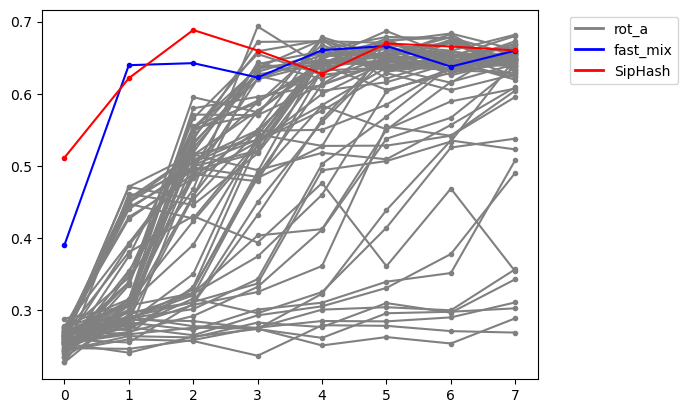

In [61]:
from matplotlib.lines import Line2D

data_grouped = data_average.groupby(['function'])

fig, ax = plt.subplots()

for name, group in data_grouped:
    if "siphash" in name:
        continue  # Skip the red line for now
    elif "fast" in name:
        continue
    else:
        color = 'gray'
        
    ax.plot(group['round'], group['score'], marker='o', linestyle='-', ms=3, color=color)

# Plot the 'red' line after plotting the 'gray' and 'blue' lines
for name, group in data_grouped:
    if "siphash" in name:
        color = 'red'
        ax.plot(group['round'], group['score'], marker='o', linestyle='-', ms=3, color=color)
    elif "fast" in name:
        color = 'blue'
        ax.plot(group['round'], group['score'], marker='o', linestyle='-', ms=3, color=color)

custom_lines = [Line2D([0], [0], color='gray', lw=2),
                Line2D([0], [0], color='blue', lw=2),
                Line2D([0], [0], color='red', lw=2)]

ax.legend(custom_lines, ['rot_a', 'fast_mix', 'SipHash'], bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()

In [62]:
test = data_average[data_average['round'] == 4]
test.sort_values('score')

,function,round,score
12,rot1,4,0.251124
476,rot62,4,0.261612
468,rot61,4,0.276554
484,rot63,4,0.279133
100,rot2,4,0.284992
...,...,...,...
356,rot49,4,0.672617
92,rot19,4,0.674063
68,rot16,4,0.674829
284,rot40,4,0.676475


In [60]:
filtered_data = data_average[data_average['round'] > 2]
average_per_function = filtered_data.groupby('function')['score'].mean()
sorted_functions = average_per_function.sort_values()
# sorted_functions

In [61]:
pd.set_option('display.max_rows', None)